In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os, sys

cwd = os.getcwd()
dirLib = cwd + r'/../library'
if dirLib not in sys.path:
    sys.path.append(dirLib)
    
from load_ARSENL_data import set_binwidth

In [10]:
load_loc = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss\fit_figures'
fname_dead = r'\params_eval_loss_dtimeTrue_order4-14_ref_shots5.00E+05_lsr_shots1.00E+05_best_fit.pkl'
fname_pois = r'\params_eval_loss_dtimeFalse_order4-14_ref_shots5.00E+05_lsr_shots1.00E+05_best_fit.pkl'

use_sim_data = False

infile_dead = open(load_loc+fname_dead, 'rb')
infile_pois = open(load_loc+fname_pois, 'rb')
load_dead = pickle.load(infile_dead)
load_pois = pickle.load(infile_pois)

In [11]:
if use_sim_data:
    t_fine = load_dead[0]
    fit_rate_seg_dead = load_dead[1]
    true_flight_time = load_dead[2]
    true_rho = load_dead[3]
    flight_time = load_dead[4]
    n_shots = load_dead[5]
    t_min = load_dead[6]
    t_max = load_dead[7]
    dt = load_dead[8]

    fit_rate_seg_pois = load_pois[1]
else:
    t_fine = load_dead[0]
    fit_rate_seg_dead = load_dead[1]
    flight_time = load_dead[2]
    n_shots = load_dead[3]
    t_min = load_dead[4]
    t_max = load_dead[5]
    dt = load_dead[6]

    fit_rate_seg_pois = load_pois[1]

IndexError: list index out of range

NameError: name 'dt' is not defined

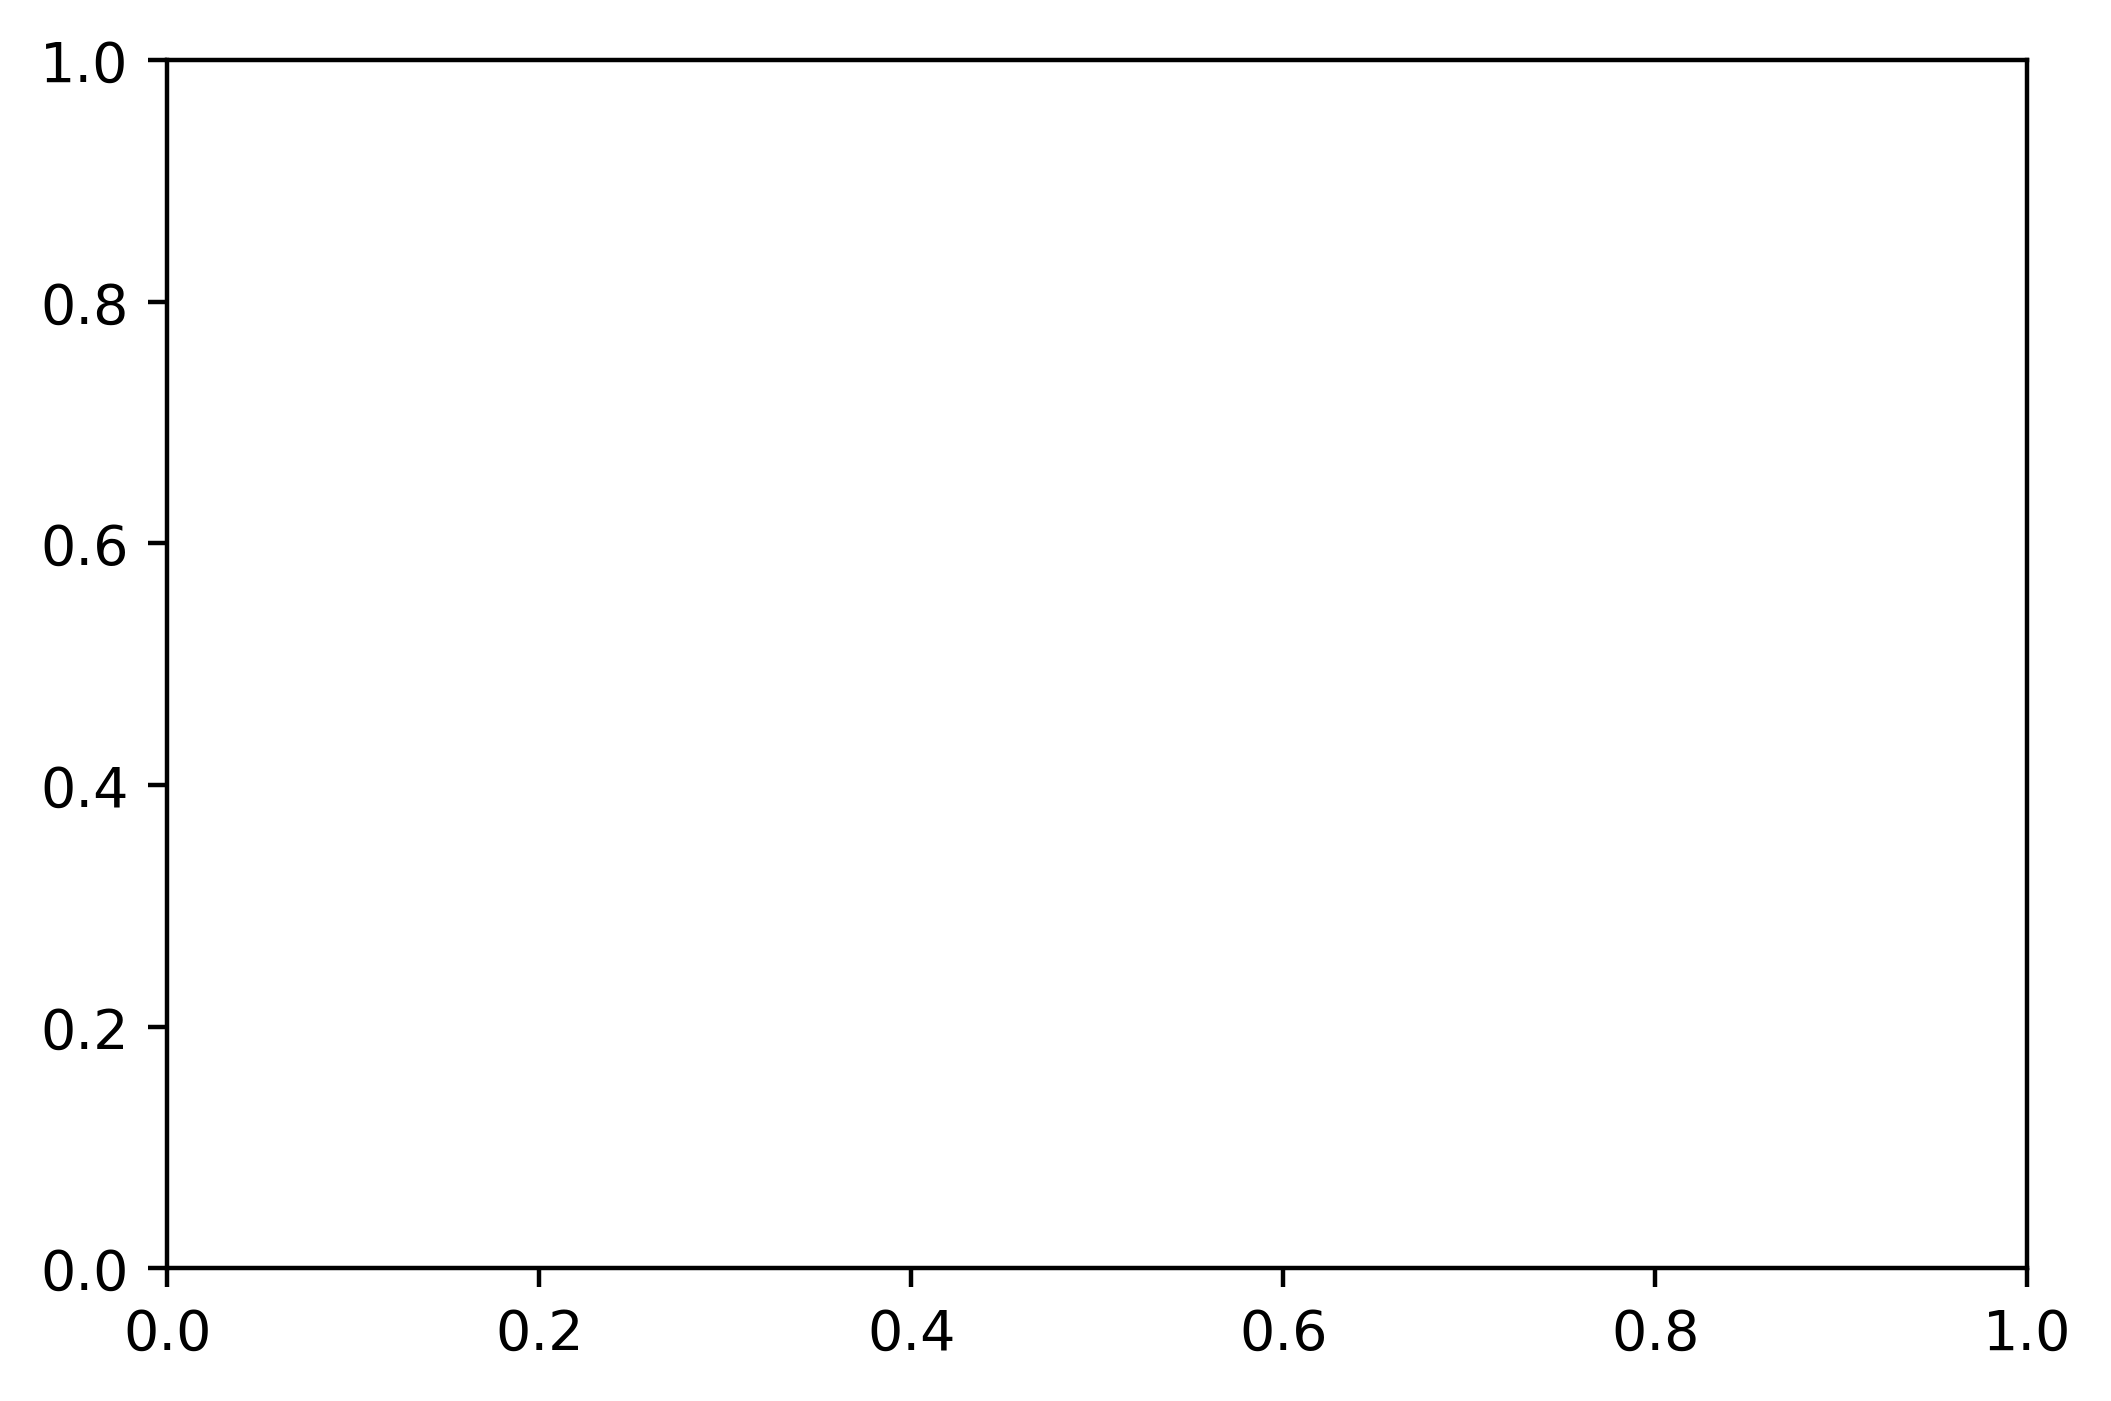

In [8]:
fig = plt.figure(figsize=(6,4), dpi=400)
ax = fig.add_subplot(111)
bin_array = set_binwidth(t_min, t_max, dt)
if use_sim_data:
    n, bins = np.histogram(true_flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='orange', alpha=0.5, label='Incident Photons')

    ax.plot(t_fine, true_rho, '--', color='orange', label='True Arrival Rate')
    n, bins = np.histogram(flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='blue', alpha=0.5, label='Detected Photons')
else:
    n, bins = np.histogram(flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='blue', alpha=0.5, label='Detected Photons')

# Arrival rate fit
ax.plot(t_fine, fit_rate_seg_dead, '-.', markersize=5, color='blue', label='Fit: Deadtime Model')
ax.plot(t_fine, fit_rate_seg_pois, '-.', markersize=5, color='black', label='Fit: Poisson Model')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# ax.text(0.1, 0.3, 'Polynomial order: {}'.format(order), transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
plt.tight_layout()
plt.legend()

save_dir = r'C:\Users\Grant\Downloads'
save_plt_file = r'\{}.png'.format(fname_dead)
fig.savefig(save_dir + save_plt_file)
plt.show()
